In [ ]:
import networkx as nx
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import sys
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from typing import List
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path sicnce we work with notebooks
from helper_functions import *
from evaluation.evalute_rag import *

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

In [40]:
class Concepts(BaseModel):
    concepts_list: List[str] = Field(description="List of concepts")

In [22]:
class GraphRAG:
    """
    A class implementing Graph-based Retrieval Augmented Generation (GraphRAG).
    This class builds a knowledge graph from documents and uses it for answering queries.
    """

    def __init__(self):
        """Initialize the GraphRAG with necessary components."""
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=4000)
        self.embeddings = OpenAIEmbeddings()
        self.graph = nx.Graph()
        self.vector_store = None
        self.lemmatizer = WordNetLemmatizer()
        self.node_content_index = None

    def process_documents(self, documents):
        """
        Process input documents to create the knowledge graph.
        
        Args:
            documents (list): List of input documents.
        """
        # Step 1: Split documents into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        splits = text_splitter.split_documents(documents)

        # Step 2: Create embeddings and vector store for efficient similarity search
        self.vector_store = FAISS.from_documents(splits, self.embeddings)

        # Step 3: Build the knowledge graph from the document splits
        self._build_knowledge_graph(splits)

        # Step 4: Create FAISS index for node contents
        node_contents = [self.graph.nodes[n]['content'] for n in self.graph.nodes]
        self.node_content_index = FAISS.from_texts(node_contents, self.embeddings)

    def _lemmatize_concept(self, concept):
        """
        Lemmatize a given concept.
        
        Args:
            concept (str): The concept to lemmatize.
        
        Returns:
            str: Lemmatized concept.
        """
        return ' '.join([self.lemmatizer.lemmatize(word) for word in word_tokenize(concept.lower())])

    def _build_knowledge_graph(self, splits):
        """
        Build the knowledge graph from document splits.
        
        Args:
            splits (list): List of document splits.
        """
        concept_to_node = {}  # For deduplication

        # Add nodes to the graph
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

        # Create edges based on semantic similarity
        embeddings = self.vector_store.embedding_function.embed_documents([split.page_content for split in splits])
        similarity_matrix = cosine_similarity(embeddings)

        # Add edges if similarity is above threshold
        threshold = 0.7  # Adjust this threshold as needed
        for i in range(len(splits)):
            for j in range(i + 1, len(splits)):
                if similarity_matrix[i][j] > threshold:
                    self.graph.add_edge(i, j, weight=similarity_matrix[i][j])

        # Extract key concepts using LLM
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts from the following text:\n\n{text}\n\nKey concepts:"
        )
        concept_chain = concept_extraction_prompt | self.llm.with_structured_output(Concepts)

        # Extract and deduplicate concepts for each node
        for node in self.graph.nodes:
            concepts = concept_chain.invoke(self.graph.nodes[node]['content']).concepts_list
            lemmatized_concepts = [self._lemmatize_concept(c) for c in concepts]
            
            # Deduplication
            unique_concepts = []
            for concept, lemma in zip(concepts, lemmatized_concepts):
                if lemma not in concept_to_node:
                    concept_to_node[lemma] = node
                    unique_concepts.append(concept)
            
            self.graph.nodes[node]['concepts'] = unique_concepts

    def query(self, query):
        """
        Process a query using the knowledge graph.
        
        Args:
            query (str): The query to process.
        
        Returns:
            str: The generated response to the query.
        """
        # Step 1: Retrieve relevant documents
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        
        # Use LLM to compress and extract relevant information
        compressor = LLMChainExtractor.from_llm(self.llm)
        compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
        
        relevant_docs = compression_retriever.get_relevant_documents(query)

        # Step 2: Expand context using graph
        expanded_context, traversal_path = self._expand_context(relevant_docs)

        # Step 3: Generate response
        response = self._generate_response(query, expanded_context)

        # Step 4: Visualize the graph traversal and print visited nodes content
        self.visualize_traversal(traversal_path)
        self.print_visited_nodes_content(traversal_path)

        return response

    def _expand_context(self, relevant_docs):
        """
        Expand the context using the knowledge graph and FAISS for efficient retrieval.
        
        Args:
            relevant_docs (list): List of relevant documents.
        
        Returns:
            tuple: Expanded context and traversal path.
        """
        expanded_context = set()
        traversal_path = []
        visited_concepts = set()

        for doc in relevant_docs:
            # Use FAISS to find the closest node
            closest_nodes = self.node_content_index.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, _ = closest_nodes[0]
            
            # Find the node in the graph that matches this content
            closest_node = next(n for n in self.graph.nodes if self.graph.nodes[n]['content'] == closest_node_content.page_content)
            
            if closest_node not in traversal_path:
                traversal_path.append(closest_node)
                expanded_context.add(self.graph.nodes[closest_node]['content'])
                
                # Check for concept similarity to avoid unnecessary revisits
                node_concepts = set(self._lemmatize_concept(c) for c in self.graph.nodes[closest_node]['concepts'])
                if not node_concepts.issubset(visited_concepts):
                    visited_concepts.update(node_concepts)
                    for neighbor in self.graph.neighbors(closest_node):
                        expanded_context.add(self.graph.nodes[neighbor]['content'])
                        neighbor_concepts = set(self._lemmatize_concept(c) for c in self.graph.nodes[neighbor]['concepts'])
                        if not neighbor_concepts.issubset(visited_concepts):
                            traversal_path.append(neighbor)
                            visited_concepts.update(neighbor_concepts)

        return list(expanded_context), traversal_path

    def _generate_response(self, query, expanded_context):
        """
        Generate a response to the query based on the expanded context.
        
        Args:
            query (str): The original query.
            expanded_context (list): List of expanded context texts.
        
        Returns:
            str: The generated response.
        """
        context = "\n\n".join(expanded_context)
        
        response_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
        )
        
        response_chain = response_prompt | self.llm
        input_data = {"query": query, "context": context}
        response = response_chain.invoke(input_data)
        
        return response.content

    def visualize_traversal(self, traversal_path):
        """
        Visualize the graph traversal.
        
        Args:
            traversal_path (list): List of nodes in the traversal path.
        """
        traversal_graph = nx.DiGraph()
        
        # Build the traversal graph
        for i, node in enumerate(traversal_path):
            traversal_graph.add_node(node)
            if i > 0:
                traversal_graph.add_edge(traversal_path[i-1], node)
            
            for neighbor in self.graph.neighbors(node):
                if neighbor not in traversal_graph:
                    traversal_graph.add_node(neighbor)
                traversal_graph.add_edge(node, neighbor)

        plt.figure(figsize=(16, 12))
        
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)
        
        # Draw all nodes with light blue color
        nx.draw(traversal_graph, pos, 
                node_color='lightblue',
                node_size=3000, 
                with_labels=False, 
                arrows=True,
                edge_color='gray')
        
        # Prepare and draw labels
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = self.graph.nodes[node].get('concepts', [])
            label = f"{i+1}. {concepts[0] if concepts else ''}"
            labels[node] = label
        
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = self.graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''
        
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold")
        
        # Draw edges of the traversal path
        path_edges = list(zip(traversal_path, traversal_path[1:]))
        nx.draw_networkx_edges(traversal_graph, pos, 
                            edgelist=path_edges, 
                            edge_color='r', 
                            width=2)
        
        # Highlight start and end points with colored outlines
        start_node = traversal_path[0]
        end_node = traversal_path[-1]
        
        # Draw start node with green outline
        nx.draw_networkx_nodes(traversal_graph, pos, 
                            nodelist=[start_node], 
                            node_color='lightblue', 
                            node_size=3000,
                            edgecolors='green',
                            linewidths=5)
        
        # Draw end node with red outline
        nx.draw_networkx_nodes(traversal_graph, pos, 
                            nodelist=[end_node], 
                            node_color='lightblue', 
                            node_size=3000,
                            edgecolors='red',
                            linewidths=5)
        
        plt.title("Graph Traversal Flow")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def print_visited_nodes_content(self, traversal_path):
        """
        Print the content of visited nodes to the console.
        
        Args:
            traversal_path (list): List of nodes in the traversal path.
        """
        print("\nContent of visited nodes in order of appearance:")
        for i, node in enumerate(traversal_path):
            print(f"\nNode {i+1}:")
            print(f"Concepts: {', '.join(self.graph.nodes[node].get('concepts', []))}")
            print(f"Content: {self.graph.nodes[node]['content'][:500]}...")  # Print first 500 characters
            print("-" * 50)

In [4]:
path = "../data/Understanding_Climate_Change.pdf"

In [5]:
loader = PyPDFLoader(path)
documents = loader.load()

In [6]:
# take only the first 5 documents
documents = documents[:5]

In [23]:
# example usage
rag = GraphRAG()

In [24]:
rag.process_documents(documents)

C:\Users\N7\AppData\Local\Temp\ipykernel_27544\811450658.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


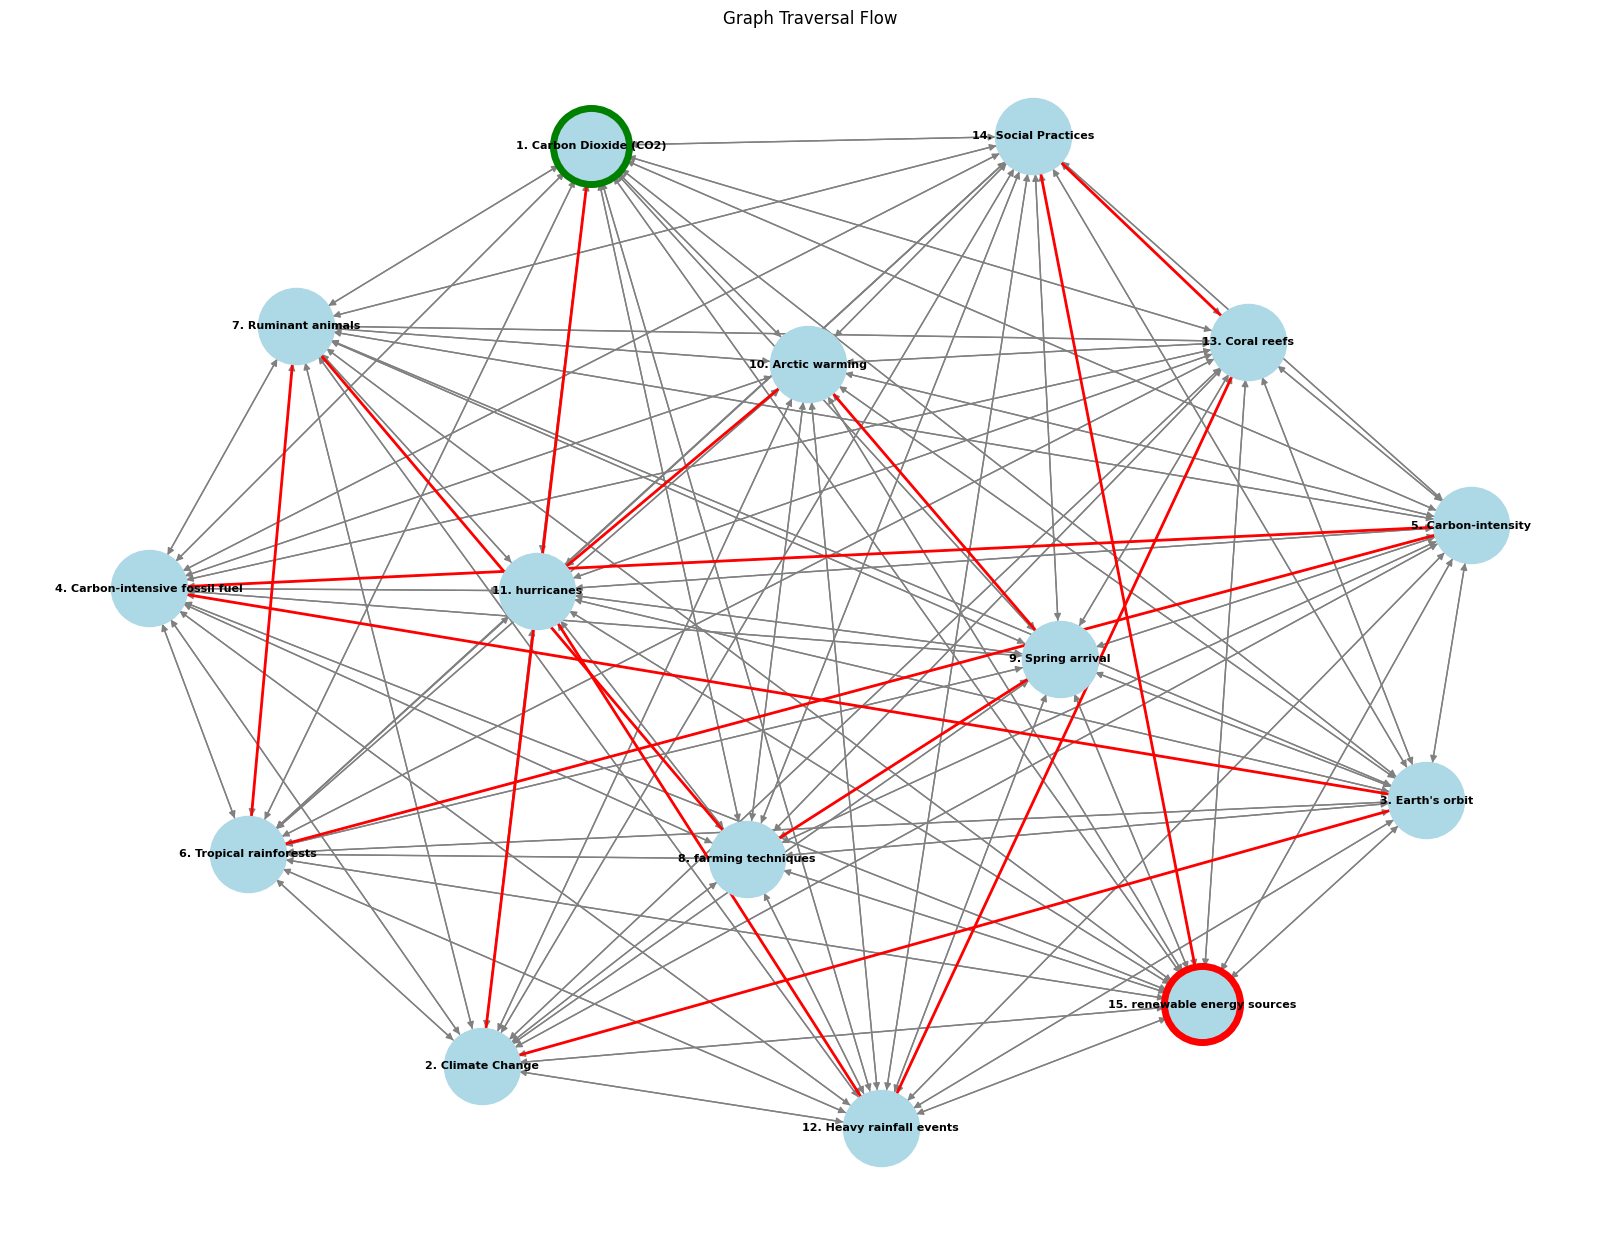


Content of visited nodes in order of appearance:

Node 1:
Concepts: Carbon Dioxide (CO2), Methane (CH4), Nitrous Oxide (N2O), Greenhouse Effect, Energy Consumption, Industrial Revolution, Coal, Oil, Natural Gas, Electricity, Heating, Transportation
Content: driven by human activities, particularly the emission of greenhou se gases.  
Chapter 2: Causes of Climate Change  
Greenhouse Gases  
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2), methane (CH4), and nitrous 
oxide (N2O), trap heat from the sun, creating a "greenhouse effect." This effect is  essential 
for life on Earth, as it keeps the planet warm enough to support life. However, human 
activit...
--------------------------------------------------

Node 2:
Concepts: Climate Change, Global Climate, Weather Patterns, Temperature, Precipitation, Wind Patterns, Human Activities, Fossil Fuels, Deforestation, Historical Context, Glacial

In [25]:
query = "What is the greenhouse effect?"
response = rag.query(query)
print(f'answer:{response}')